# Intro



Starter notebook for [Hotel-ID to Combat Human Trafficking 2022 - FGVC9](https://www.kaggle.com/competitions/hotel-id-to-combat-human-trafficking-2022-fgvc9) competition using model to generate embeddings as image representation and then searching for the most similar images. 

Inference notebook: [Hotel-ID starter - similarity- inference](https://www.kaggle.com/code/michaln/hotel-id-starter-similarity-inference)

## Embeddings
To compare images we can use model to generate embeddings as their representation and then calculate distance/similarity between images to search for the most similar one.

We can use pretrained model without the last classification layer and add two linear layers. Features from pretrianed CNN will be used as input for embedding layer and result of embedding layer will be used for classification layer. Model will then output embeddings and predicted class. We can use a class prediction to calculate loss and train the model further and embeddings to search for similar images. Embeddings should contain enough information to predict correct class so they should be good representations of the image. 

![Embedding model](https://github.com/michal-nahlik/kaggle-hotel-id-2022/raw/master/doc/img/embedding_model.png)

## Similarity
To find if images are similar we can calculate distance/similarity of their emebeddings using methods like [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) or [Cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity).

After training model we can get embeddings for all images with known class (hotel id) and calculate their similarity to the test image we want to classify. We can rank the train images based on their similarity to embeddings of the test image and find 5 train images from different hotels that are most similar.

## Data
This notebook uses preprocessed images that were resized and padded to 256x256 pixel.

Used dataset: [Hotel-ID 2022 train images 256x256](https://www.kaggle.com/datasets/michaln/hotelid-2022-train-images-256x256) created by [Hotel-ID - image preprocessing - 256x256](https://www.kaggle.com/code/michaln/hotel-id-image-preprocessing-256x256) notebook.

## Classification starter notebook
Previous starter notebook using simple classification:
- [Hotel-ID starter - classification - traning](https://www.kaggle.com/code/michaln/hotel-id-starter-classification-traning)
- [Hotel-ID starter - classification - inference](https://www.kaggle.com/code/michaln/hotel-id-starter-classification-inference)

This notebook has similar structure and is extension of it to show different approach.

# Imports

In [1]:
#!pip install torchviz

In [2]:
!pip install timm

     |████████████████████████████████| 431 kB 289 kB/s            


In [3]:
import numpy as np
import pandas as pd
import random
import os

In [4]:
from PIL import Image as pil_image
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import timm

from sklearn.metrics.pairwise import cosine_similarity

# Global

In [6]:
IMG_SIZE = 256
SEED = 42
N_MATCHES = 5

PROJECT_FOLDER = "../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/"
DATA_FOLDER = "../input/hotelid-2022-train-images-256x256/"
IMAGE_FOLDER = DATA_FOLDER + "images/"
OUTPUT_FOLDER = ""

train_df = pd.read_csv(os.path.join(DATA_FOLDER, 'train.csv'))

In [7]:
print(os.listdir(PROJECT_FOLDER))

['sample_submission.csv', 'train_images', 'train_masks', 'test_images']


In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Dataset and transformations

Coarse dropout with fill_value=(255,0,0) (full red channel) is used to simulate the occlussions like the one in test dataset. 
```python
A.CoarseDropout(p=1., max_holes=1, 
                min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                fill_value=(255,0,0))
```

In [9]:
import albumentations as A
import albumentations.pytorch as APT
import cv2 

# used for training dataset - augmentations and occlusions
train_transform = A.Compose([
    A.HorizontalFlip(p=0.75),
    A.VerticalFlip(p=0.25),
    A.ShiftScaleRotate(p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.OpticalDistortion(p=0.25),
    A.Perspective(p=0.25),
    A.CoarseDropout(p=0.5, min_holes=1, max_holes=6, 
                    min_height=IMG_SIZE//16, max_height=IMG_SIZE//4,
                    min_width=IMG_SIZE//16,  max_width=IMG_SIZE//4), # normal coarse dropout
    
    A.CoarseDropout(p=1., max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions in test data

    A.RandomBrightnessContrast(p=0.75),
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# used for validation dataset - only occlusions
val_transform = A.Compose([
    A.CoarseDropout(p=1., max_holes=1, 
                    min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                    min_width=IMG_SIZE//4,  max_width=IMG_SIZE//2, 
                    fill_value=(255,0,0)),# simulating occlusions
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

# no augmentations
base_transform = A.Compose([
    A.ToFloat(),
    APT.transforms.ToTensorV2(),
])

In [10]:
class HotelTrainDataset:
    def __init__(self, data, transform=None, data_path="train_images/"):
        self.data = data
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        record = self.data.iloc[idx]
        image_path = self.data_path + record["image_id"]
        image = np.array(pil_image.open(image_path)).astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed["image"]
        
        return {
            "image" : image,
            "target" : record['hotel_id_code'],
        }

# Model
Model uses pretrained CNN without classification layer. Features from CNN are used as input for embedding layer (linear) and embeddings are used for final classification. Model can output both embeddings and class prediction or just embeddings.

Input image -> [CNN] -> features -> [Embedding layer] -> embeddings -> [Classification layer] -> class prediction

In [11]:
class EmbeddingModel(nn.Module):
    def __init__(self, n_classes=100, embedding_size=64, backbone_name="efficientnet_b0"):
        super(EmbeddingModel, self).__init__()
        
        self.backbone = timm.create_model(backbone_name, num_classes=n_classes, pretrained=True)
        in_features = self.backbone.get_classifier().in_features
        
        self.backbone.classifier = nn.Identity()
        self.embedding = nn.Linear(in_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)

    def embed_and_classify(self, x):
        x = self.forward(x)
        return x, self.classifier(x)

    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        return x

# Model helper functions

In [12]:
# method to iterate loader and generate embeddings of images
# returns embeddings and image class
def generate_embeddings(loader, model, bar_desc="Generating embeds"):
    targets_all = []
    outputs_all = []
    
    model.eval()
    with torch.no_grad():
        t = tqdm(loader, desc=bar_desc)
        for i, sample in enumerate(t):
            input = sample['image'].to(args.device)
            target = sample['target'].to(args.device)
            output = model(input)
            
            targets_all.extend(target.cpu().numpy())
            outputs_all.extend(output.detach().cpu().numpy())

    targets_all = np.array(targets_all).astype(np.float32)
    outputs_all = np.array(outputs_all).astype(np.float32)
            
    return outputs_all, targets_all

In [13]:
def save_checkpoint(model, scheduler, optimizer, epoch, name, loss=None, score=None):
    checkpoint = {"epoch": epoch,
                  "model": model.state_dict(),
                  "scheduler": scheduler.state_dict(),
                  "optimizer": optimizer.state_dict(),
                  "loss": loss,
                  "score": score,
                  }

    torch.save(checkpoint, f"{OUTPUT_FOLDER}checkpoint-{name}.pt")


def load_checkpoint(model, scheduler, optimizer, name):
    checkpoint = torch.load(f"{OUTPUT_FOLDER}checkpoint-{name}.pt")

    model.load_state_dict(checkpoint["model"])
    scheduler.load_state_dict(checkpoint["scheduler"])
    return model, scheduler, optimizer, checkpoint["epoch"]

# Train and validation functions

In [14]:
pip install pytorch_metric_learning

     |████████████████████████████████| 109 kB 296 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [15]:
from pytorch_metric_learning import miners
from pytorch_metric_learning import losses as pytorch_losses
from pytorch_metric_learning.distances import CosineSimilarity
from pytorch_metric_learning.reducers import ThresholdReducer
from pytorch_metric_learning.regularizers import LpRegularizer

def train_epoch(args, model, loader, criterion, optimizer, scheduler, epoch):
    miner = miners.MultiSimilarityMiner()
    loss_func = pytorch_losses.ArcFaceLoss(args.n_classes, args.embedding_size)
    losses = []
    targets_all = []
    outputs_all = []
    
    model.train()
    t = tqdm(loader)
    
    for i, sample in enumerate(t):
        optimizer.zero_grad()
        
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        embeddings, outputs = model.embed_and_classify(images)
        hard_pairs = miner(embeddings, targets)#
        loss_emb = loss_func(embeddings, targets, hard_pairs)#
        loss_class = criterion(outputs, targets)
        loss = loss_emb + loss_class
        loss.backward()
        #loss_class.backward()
        optimizer.step()
        
        if scheduler:
            scheduler.step()
                
        losses.append(loss.item())
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())

        score = np.mean(targets_all == np.argmax(outputs_all, axis=1))
        desc = f"Training epoch {epoch}/{args.epochs} - loss:{loss:0.4f}, accuracy: {score:0.4f}"
        t.set_description(desc)
        
    return np.mean(losses), score

In [16]:
def test_classification(loader, model):
    targets_all = []
    outputs_all = []
    
    model.eval()
    t = tqdm(loader, desc="Classification")
    
    for i, sample in enumerate(t):
        images = sample['image'].to(args.device)
        targets = sample['target'].to(args.device)
        
        _, outputs = model.embed_and_classify(images)
        
        targets_all.extend(targets.cpu().numpy())
        outputs_all.extend(torch.sigmoid(outputs).detach().cpu().numpy())
        
    
    # repeat targets to N_MATCHES for easy calculation of MAP@5
    y = np.repeat([targets_all], repeats=N_MATCHES, axis=0).T
    # sort predictions and get top 5
    preds = np.argsort(-np.array(outputs_all), axis=1)[:, :N_MATCHES]
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == y).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(targets_all == np.argmax(outputs_all, axis=1))

    print(f"Classification accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

In [17]:
# find 5 most similar images from different hotels and return their hotel_id_code
def find_matches(query, base_embeds, base_targets, k=N_MATCHES):
    distance_df = pd.DataFrame(index=np.arange(len(base_targets)), data={"hotel_id_code": base_targets})
    # calculate cosine distance of query embeds to all base embeds
    distance_df["distance"] = cosine_similarity([query], base_embeds)[0]
    # sort by distance and hotel_id
    distance_df = distance_df.sort_values(by=["distance", "hotel_id_code"], ascending=False).reset_index(drop=True)
    # return first 5 different hotel_id_codes
    return distance_df["hotel_id_code"].unique()[:N_MATCHES]
    

def test_similarity(args, base_loader, test_loader, model):
    base_embeds, base_targets = generate_embeddings(base_loader, model, "Generate base embeddings")
    test_embeds, test_targets = generate_embeddings(test_loader, model, "Generate test embeddings")
    
    preds = []
    for query_embeds in tqdm(test_embeds, desc="Similarity - match finding"):
        tmp = find_matches(query_embeds, base_embeds, base_targets)
        preds.extend([tmp])
        
    preds = np.array(preds)
    test_targets_N = np.repeat([test_targets], repeats=N_MATCHES, axis=0).T
    # check if any of top 5 predictions are correct and calculate mean accuracy
    acc_top_5 = (preds == test_targets_N).any(axis=1).mean()
    # calculate prediction accuracy
    acc_top_1 = np.mean(test_targets == preds[:, 0])
    print(f"Similarity accuracy: {acc_top_1:0.4f}, MAP@5: {acc_top_5:0.4f}")

# Prepare data

In [18]:
data_df = pd.read_csv(DATA_FOLDER + "train.csv")
room_data = pd.read_csv('../input/hotel-id-room-type-classifier-public-04db40/room-types.csv')
room_df = room_data["room_type"]
room_col = room_df.values
id_room = room_col
id_ = data_df['hotel_id'].values
print(data_df)
for i in range(len(id_room)):
    if id_room[i] == 'bedroom':
        id_room[i] = str(id_[i]) + '0'
    elif id_room[i] == 'bathroom':
        id_room[i] = str(id_[i]) + '1'
    else:
        id_room[i] = str(id_[i]) + '2'


#data_df['room_type'] = room_col
data_df['hotel_id'] = (id_room)
print(data_df)

            image_id  hotel_id
0      000011648.jpg     15526
1      000011630.jpg     15526
2      000011650.jpg     15526
3      000011633.jpg     15526
4      000011656.jpg     15526
...              ...       ...
44698  000021849.jpg     95605
44699  000021854.jpg     95605
44700  000021853.jpg     95605
44701  000021850.jpg     95605
44702  000021852.jpg     95605

[44703 rows x 2 columns]
            image_id hotel_id
0      000011648.jpg   155262
1      000011630.jpg   155260
2      000011650.jpg   155262
3      000011633.jpg   155261
4      000011656.jpg   155261
...              ...      ...
44698  000021849.jpg   956050
44699  000021854.jpg   956051
44700  000021853.jpg   956050
44701  000021850.jpg   956050
44702  000021852.jpg   956050

[44703 rows x 2 columns]


In [19]:
#data_df = pd.read_csv(DATA_FOLDER + "train.csv")
# encode hotel ids
data_df["hotel_id_code"] = data_df["hotel_id"].astype('category').cat.codes.values.astype(np.int64)

In [20]:
data_df

,image_id,hotel_id,hotel_id_code
0,000011648.jpg,155262,994
1,000011630.jpg,155260,992
2,000011650.jpg,155262,994
3,000011633.jpg,155261,993
4,000011656.jpg,155261,993
...,...,...,...
44698,000021849.jpg,956050,8205
44699,000021854.jpg,956051,8206
44700,000021853.jpg,956050,8205
44701,000021850.jpg,956050,8205


In [21]:
# save hotel_id encoding for later decoding
hotel_id_code_df = data_df.drop(columns=["image_id"]).drop_duplicates().reset_index(drop=True)
hotel_id_code_df.to_csv(OUTPUT_FOLDER + 'hotel_id_code_mapping.csv', index=False)
# hotel_id_code_map = hotel_id_code_df.set_index('hotel_id_code').to_dict()["hotel_id"]

# Quick look at data

We can see that most hotels have less than 20 images while there are few with over hundreds and one with over 1000. In case of classification weights or sampling might be useful to handle the imbalance. There is also 11 hotels with only 1 image so we should think about how to deal with them.

## Image count per hotel

In [22]:
group_df = data_df.groupby(["hotel_id"]).size().to_frame("image_count").sort_values("image_count")[::-1].reset_index()

# top and low
low_df = group_df.iloc[-50:]
top_df = group_df.iloc[:50]

fig = make_subplots(rows=2, cols=2, 
                    specs=[[{"colspan": 2}, None], [{}, {}]],
                    horizontal_spacing=0.02, vertical_spacing=0.2, 
                    shared_yaxes=False,
                    subplot_titles=("", "Top 50", "Bottom 50"))


fig.add_trace(go.Scatter(x=group_df["hotel_id"], y=group_df["image_count"], showlegend = False), 1, 1)
fig.add_trace(go.Bar(x=top_df["hotel_id"], y=top_df["image_count"], showlegend = False), 2, 1)
fig.add_trace(go.Bar(x=low_df["hotel_id"], y=low_df["image_count"], showlegend = False), 2, 2)

fig.update_yaxes(title_text="Image count", row=1, col=1)
fig.update_yaxes(title_text="Image count", row=2, col=1)
fig.update_xaxes(type="category", visible=False, row=1, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=1)
fig.update_xaxes(title_text="Hotel ID", type="category", row=2, col=2)

fig.update_layout(title="Image count per hotel", height=550)
fig.show()

In [23]:
fig = px.histogram(group_df, x="image_count", nbins=100, marginal="box", height=350)
fig.update_layout(title="Distribution of image count per hotel")
fig.update_traces(hovertemplate="Image count: %{x} <br>Hotel count: %{y}")
fig.show()

## Example of images

In [24]:
def show_images(ds, title_text, n_images=5):
    fig, ax = plt.subplots(1,5, figsize=(22,8))
    
    ax[0].set_ylabel(title_text)
    
    for i in range(5):
        d = ds.__getitem__(i)
        ax[i].imshow(d["image"].T)

### Train images without and with augmentations

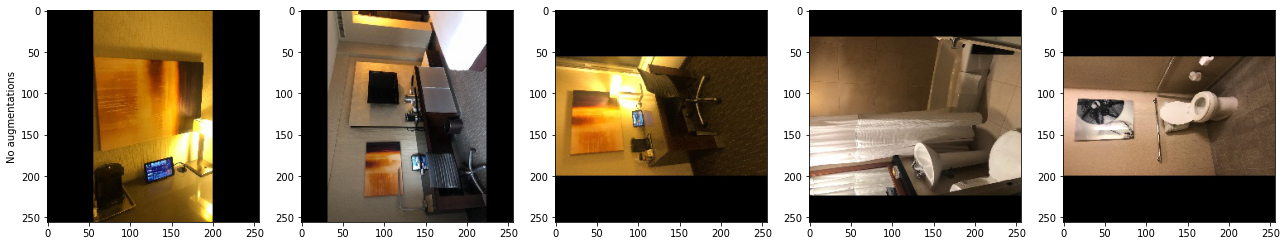

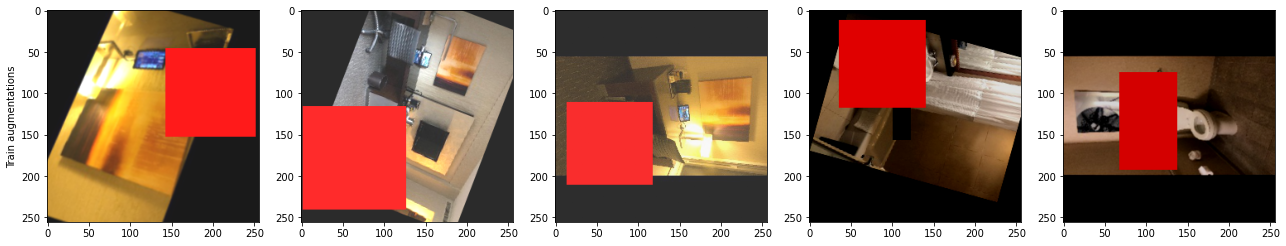

In [25]:
train_dataset = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'No augmentations')

train_dataset = HotelTrainDataset(data_df, train_transform, data_path=IMAGE_FOLDER)
show_images(train_dataset, 'Train augmentations')

### Test image example with occlusion

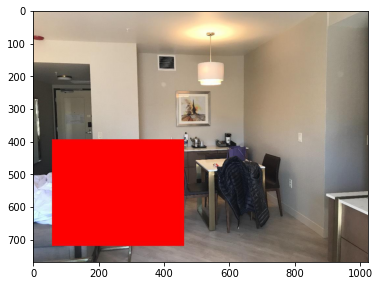

In [26]:
test_image = np.array(pil_image.open('../input/hotel-id-to-combat-human-trafficking-2022-fgvc9/test_images/abc.jpg')).astype(np.uint8)
plt.figure(figsize=(6,6))
plt.imshow(test_image)

# Train and evaluate

In [27]:


def train_and_validate(args, data_df):
    model_name = f"embedding-model-{args.backbone_name}-{IMG_SIZE}x{IMG_SIZE}"
    print(model_name)

    seed_everything(seed=SEED)

    # split data into train and validation set
    hotel_image_count = data_df.groupby("hotel_id")["image_id"].count()
    # hotels that have more images than samples for validation
    valid_hotels = hotel_image_count[hotel_image_count > args.val_samples]
    # data that can be split into train and val set
    valid_data = data_df[data_df["hotel_id"].isin(valid_hotels.index)]
    # if hotel had less than required val_samples it will be only in the train set
    valid_df = valid_data.groupby("hotel_id").sample(args.val_samples, random_state=SEED)
    train_df = data_df[~data_df["image_id"].isin(valid_df["image_id"])]
    
    #Calculate the class weights https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/
    a = train_df.copy()
    a['hotel_id'] = a['hotel_id'].astype('str')
    hotel_count = (a.groupby('hotel_id')['image_id'].count())
    hotel_count = (np.sum(hotel_count)/(len(a['image_id'].unique()) * hotel_count))
    class_weights = torch.FloatTensor(list(hotel_count)).cuda()
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    train_dataset = HotelTrainDataset(train_df, train_transform, data_path=IMAGE_FOLDER)
    train_loader  = DataLoader(train_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=True, drop_last=True)
    valid_dataset = HotelTrainDataset(valid_df, val_transform, data_path=IMAGE_FOLDER)
    valid_loader  = DataLoader(valid_dataset, num_workers=args.num_workers, batch_size=args.batch_size, shuffle=False)
    # base dataset for image similarity search
    base_dataset  = HotelTrainDataset(train_df, base_transform, data_path=IMAGE_FOLDER)
    base_loader   = DataLoader(base_dataset, num_workers=args.num_workers, batch_size=args.batch_size*4, shuffle=False)

    model = EmbeddingModel(args.n_classes, args.embedding_size ,args.backbone_name)
    model = model.to(args.device)
  
    #criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr)

    scheduler = torch.optim.lr_scheduler.OneCycleLR(
                    optimizer,
                    max_lr=args.lr,
                    epochs=args.epochs,
                    steps_per_epoch=len(train_loader),
                    div_factor=10,
                    final_div_factor=1,
                    pct_start=0.1,
                    anneal_strategy="cos",
                )
    
    start_epoch = 1
    
    for epoch in range(start_epoch, args.epochs+1):
        train_loss, train_score = train_epoch(args, model, train_loader, criterion, optimizer, scheduler, epoch)
        save_checkpoint(model, scheduler, optimizer, epoch, model_name, train_loss, train_score)
        test_classification(valid_loader, model)

    test_similarity(args, base_loader, valid_loader, model)
    
    # generate embeddings for all train images and save them for inference
    base_dataset   = HotelTrainDataset(data_df, base_transform, data_path=IMAGE_FOLDER)
    base_loader    = DataLoader(base_dataset, num_workers=args.num_workers, batch_size=args.batch_size*4, shuffle=False)
    base_embeds, _ = generate_embeddings(base_loader, model, "Generate embeddings for all images")
    data_df["embeddings"] = list(base_embeds)
    data_df.to_pickle(f"{OUTPUT_FOLDER}{model_name}_image-embeddings.pkl")

## Efficientnet-b0 training

In [28]:
%%time 

class args:
    epochs = 25
    lr = 1e-3
    batch_size = 64
    num_workers = 2
    val_samples = 1
    embedding_size = 512
    backbone_name = "efficientnet_b0"
    n_classes = data_df["hotel_id_code"].nunique()
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    
    
train_and_validate(args, data_df)

embedding-model-efficientnet_b0-256x256


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b0_ra-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_ra-3dd342df.pth
Training epoch 1/25 - loss:14.0567, accuracy: 0.0479: 100%|██████████| 592/592 [08:48<00:00,  1.12it/s]
Classification: 100%|██████████| 107/107 [00:46<00:00,  2.30it/s]


Classification accuracy: 0.0031, MAP@5: 0.0063


Training epoch 2/25 - loss:10.1008, accuracy: 0.1103: 100%|██████████| 592/592 [08:09<00:00,  1.21it/s]
Classification: 100%|██████████| 107/107 [00:23<00:00,  4.62it/s]


Classification accuracy: 0.0068, MAP@5: 0.0159


Training epoch 3/25 - loss:47.8220, accuracy: 0.1193: 100%|██████████| 592/592 [08:05<00:00,  1.22it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.75it/s]


Classification accuracy: 0.0222, MAP@5: 0.0565


Training epoch 4/25 - loss:46.6738, accuracy: 0.1490: 100%|██████████| 592/592 [08:11<00:00,  1.20it/s]
Classification: 100%|██████████| 107/107 [00:23<00:00,  4.54it/s]


Classification accuracy: 0.0634, MAP@5: 0.1447


Training epoch 5/25 - loss:41.3304, accuracy: 0.2095: 100%|██████████| 592/592 [08:14<00:00,  1.20it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.75it/s]


Classification accuracy: 0.1092, MAP@5: 0.2184


Training epoch 6/25 - loss:5.5521, accuracy: 0.3219: 100%|██████████| 592/592 [08:24<00:00,  1.17it/s]
Classification: 100%|██████████| 107/107 [00:24<00:00,  4.42it/s]


Classification accuracy: 0.1364, MAP@5: 0.2616


Training epoch 7/25 - loss:41.0144, accuracy: 0.4295: 100%|██████████| 592/592 [08:18<00:00,  1.19it/s]
Classification: 100%|██████████| 107/107 [00:23<00:00,  4.53it/s]


Classification accuracy: 0.1556, MAP@5: 0.3056


Training epoch 8/25 - loss:3.4455, accuracy: 0.4530: 100%|██████████| 592/592 [08:05<00:00,  1.22it/s]
Classification: 100%|██████████| 107/107 [00:23<00:00,  4.61it/s]


Classification accuracy: 0.1665, MAP@5: 0.3438


Training epoch 9/25 - loss:3.3550, accuracy: 0.4622: 100%|██████████| 592/592 [08:17<00:00,  1.19it/s]
Classification: 100%|██████████| 107/107 [00:26<00:00,  4.09it/s]


Classification accuracy: 0.1580, MAP@5: 0.3422


Training epoch 10/25 - loss:1.7700, accuracy: 0.4505: 100%|██████████| 592/592 [08:30<00:00,  1.16it/s]
Classification: 100%|██████████| 107/107 [00:25<00:00,  4.27it/s]


Classification accuracy: 0.1434, MAP@5: 0.3378


Training epoch 11/25 - loss:3.8667, accuracy: 0.4329: 100%|██████████| 592/592 [08:13<00:00,  1.20it/s]
Classification: 100%|██████████| 107/107 [00:23<00:00,  4.57it/s]


Classification accuracy: 0.1334, MAP@5: 0.3334


Training epoch 12/25 - loss:35.3844, accuracy: 0.4295: 100%|██████████| 592/592 [08:16<00:00,  1.19it/s]
Classification: 100%|██████████| 107/107 [00:23<00:00,  4.63it/s]


Classification accuracy: 0.1339, MAP@5: 0.3432


Training epoch 13/25 - loss:2.8897, accuracy: 0.3898: 100%|██████████| 592/592 [08:17<00:00,  1.19it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.66it/s]


Classification accuracy: 0.1010, MAP@5: 0.2979


Training epoch 14/25 - loss:36.8276, accuracy: 0.3697: 100%|██████████| 592/592 [07:51<00:00,  1.26it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.86it/s]


Classification accuracy: 0.0832, MAP@5: 0.2672


Training epoch 15/25 - loss:31.2780, accuracy: 0.3457: 100%|██████████| 592/592 [08:11<00:00,  1.21it/s]
Classification: 100%|██████████| 107/107 [00:26<00:00,  4.08it/s]


Classification accuracy: 0.0967, MAP@5: 0.2915


Training epoch 16/25 - loss:2.1958, accuracy: 0.3399: 100%|██████████| 592/592 [08:06<00:00,  1.22it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.84it/s]


Classification accuracy: 0.0859, MAP@5: 0.2798


Training epoch 17/25 - loss:3.5019, accuracy: 0.3239: 100%|██████████| 592/592 [08:17<00:00,  1.19it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.67it/s]


Classification accuracy: 0.0684, MAP@5: 0.2425


Training epoch 18/25 - loss:37.3017, accuracy: 0.2973: 100%|██████████| 592/592 [08:17<00:00,  1.19it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.76it/s]


Classification accuracy: 0.0690, MAP@5: 0.2454


Training epoch 19/25 - loss:33.7784, accuracy: 0.3384: 100%|██████████| 592/592 [08:27<00:00,  1.17it/s]
Classification: 100%|██████████| 107/107 [00:25<00:00,  4.22it/s]


Classification accuracy: 0.0941, MAP@5: 0.3092


Training epoch 20/25 - loss:38.5770, accuracy: 0.4057: 100%|██████████| 592/592 [08:28<00:00,  1.16it/s]
Classification: 100%|██████████| 107/107 [00:29<00:00,  3.66it/s]


Classification accuracy: 0.1127, MAP@5: 0.3362


Training epoch 21/25 - loss:39.0020, accuracy: 0.4614: 100%|██████████| 592/592 [08:03<00:00,  1.23it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.68it/s]


Classification accuracy: 0.1216, MAP@5: 0.3500


Training epoch 22/25 - loss:2.2512, accuracy: 0.5109: 100%|██████████| 592/592 [08:24<00:00,  1.17it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.70it/s]


Classification accuracy: 0.1550, MAP@5: 0.3880


Training epoch 23/25 - loss:35.4439, accuracy: 0.5300: 100%|██████████| 592/592 [08:10<00:00,  1.21it/s]
Classification: 100%|██████████| 107/107 [00:24<00:00,  4.42it/s]


Classification accuracy: 0.1607, MAP@5: 0.3883


Training epoch 24/25 - loss:37.2503, accuracy: 0.5773: 100%|██████████| 592/592 [08:34<00:00,  1.15it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.80it/s]


Classification accuracy: 0.1836, MAP@5: 0.4165


Training epoch 25/25 - loss:36.7658, accuracy: 0.6592: 100%|██████████| 592/592 [08:21<00:00,  1.18it/s]
Classification: 100%|██████████| 107/107 [00:22<00:00,  4.66it/s]


Classification accuracy: 0.2098, MAP@5: 0.4353


Similarity - match finding: 100%|██████████| 6812/6812 [18:24<00:00,  6.17it/s]


Similarity accuracy: 0.3644, MAP@5: 0.4896


Generate embeddings for all images: 100%|██████████| 175/175 [02:18<00:00,  1.27it/s]


CPU times: user 2h 51min, sys: 58min 18s, total: 3h 49min 18s
Wall time: 4h 2min 52s
